# WORK IN PROGRESS

## PDF figure creation

The objective of this notebook is to create all graphs to generate a figure that allows you to look at your datas. 
In this, we want to create functions to create the plots (based on Step-by-Step-Processing), and then to generate an full figure. 
Then, we want to create a PDF that contains the figure. Each page on the PDF should be one session. 

In [2]:
# Imports

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath

from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from processing_TowerCoordinates import *

In [3]:
# Take one mouse as an example

path_to_data_folder = '/home/david/MyLocalData/Maud/' # Maud work computer
# path_to_data_folder = 'C:/Users/mauds/Documents' # Maud personal computer
pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

mice_list: list[str] = ["MOU4551"]

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions')
    # print(session_list[mouse], '\n')

Hello, I'm MOU4551! I have foraged for 46 sessions


In [4]:
# Get only one session to process

folder_path_mouse_to_process=os.path.join(path_to_data_folder,mice_list[0])
print(folder_path_mouse_to_process)

session_to_process=session_list[mice_list[0]][42]
print(session_to_process)

/home/david/MyLocalData/Maud/MOU4551
MOU4551_20240808-1159


In [5]:
# Import the pickle file

# Full path to the pickle file
output_pickle_filepath = f"{folder_path_mouse_to_process}/{session_to_process}/{session_to_process}_basic_processing_output.pickle"

# Import pickle file
with open(output_pickle_filepath, 'rb') as f:
    data = pickle.load(f)

# Print keys of the dictionnary
for key, value in data.items():
    print(key)


timeofframes
positions
distances
speeds
angular_speeds
distance_ran
average_speed
all_epochs
run_around_tower_sessionresult
all_trapezes_coordinates_cm
towers_coordinates_cm


In [6]:
# Create some variables from the pickle and calculate total distance ran

X_positions_cm = data['positions'][0]
Y_positions_cm = data['positions'][1]
average_speed = data['average_speed']
distances = data['distances']
speeds = data['speeds']
angular_speeds = data['angular_speeds']
all_epochs = data['all_epochs']
traject_time = data['timeofframes']
run_around_tower_results = data['run_around_tower_sessionresult']
timeofframes = data['timeofframes']
runs_around_tower = all_epochs['run_around_tower']
trapezes_coordinates = data['all_trapezes_coordinates_cm']
towers_coordinates = data['towers_coordinates_cm']

total_distance = np.sum(distances)/100 # Calculate total distance in meters

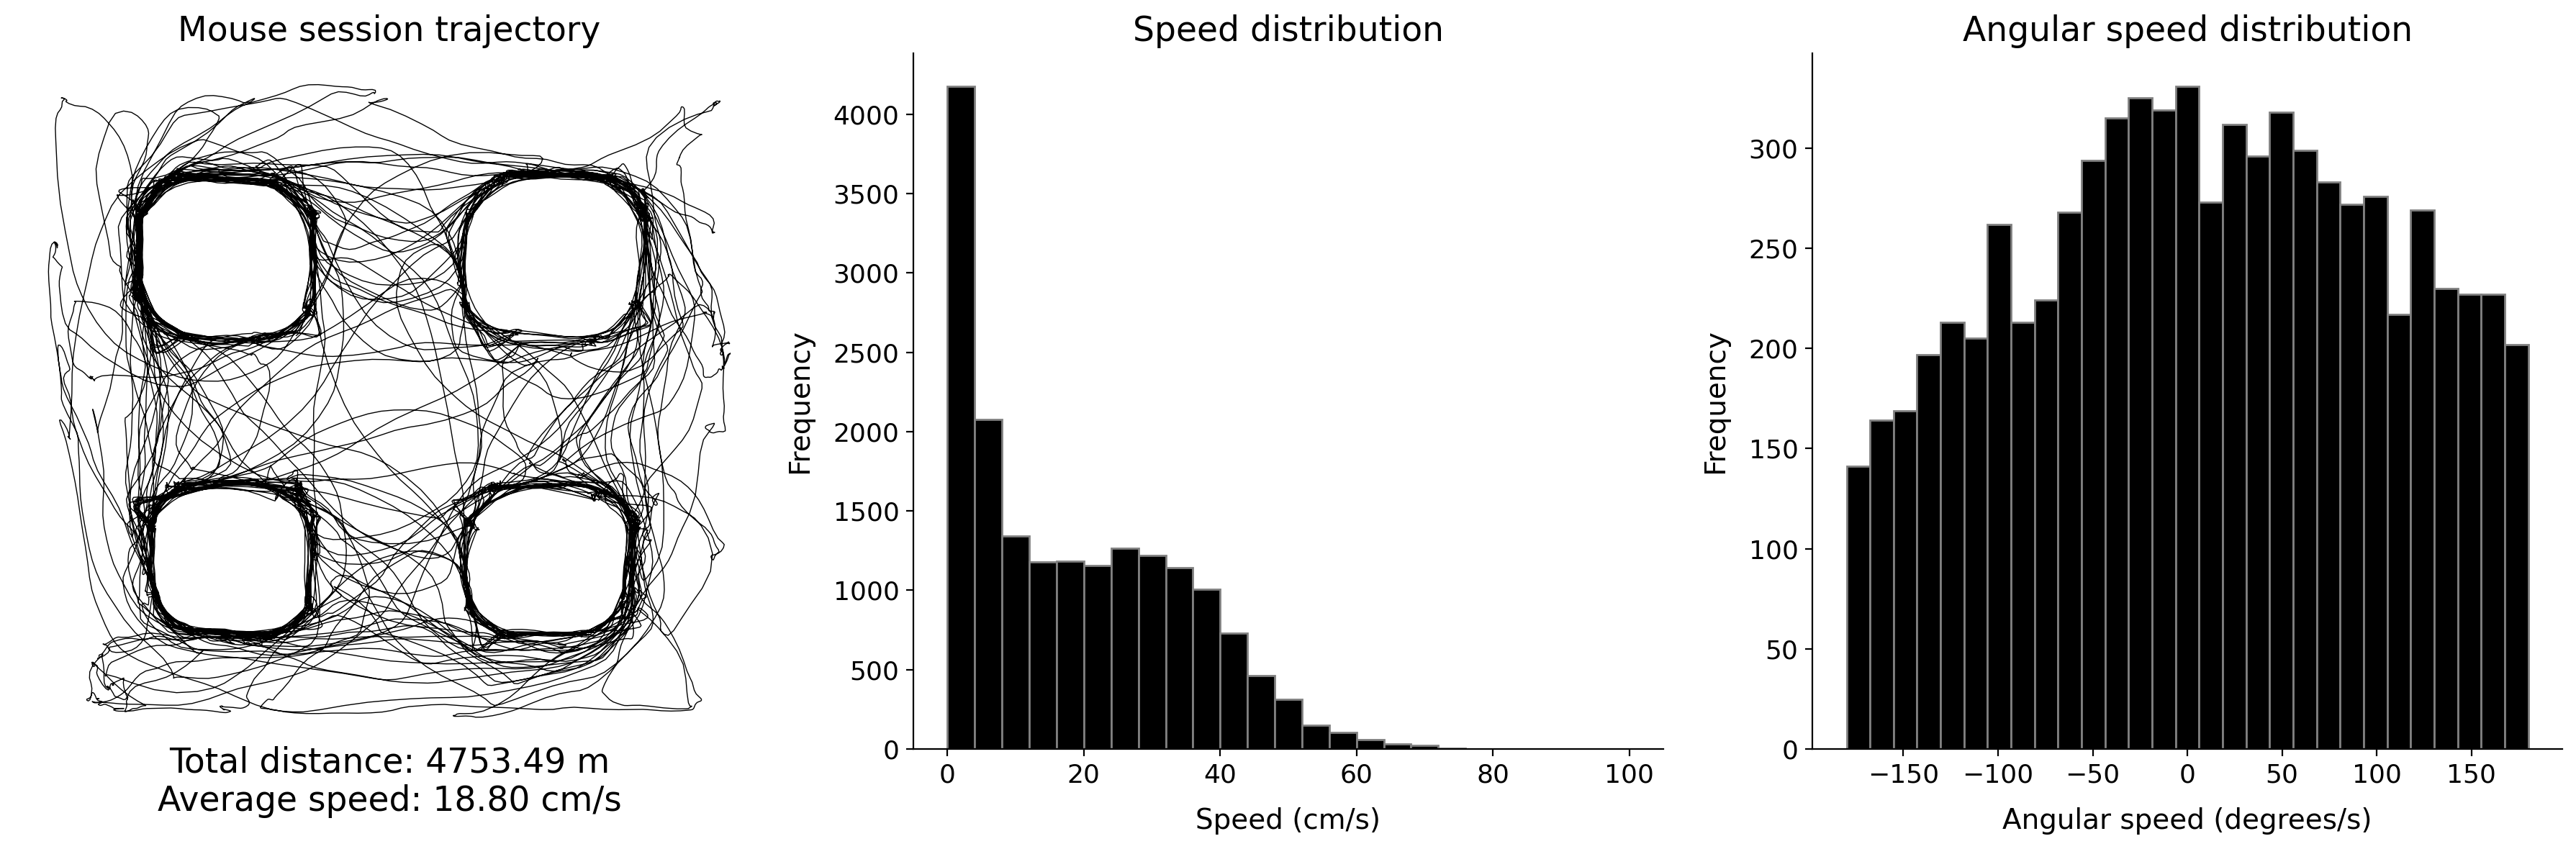

In [113]:
# Functions to plot trajectory, speeds distribution and angular speeds distribution

def plot_trajectory(ax, X_positions_cm, Y_positions_cm, total_distance, average_speed):
    """
    Plots the mouse trajectory on the given axis with total distance and average speed.

    ax: define the axe in which the plot will be
    X_positions_cm: dictionnary of every X positions in cm, found in pickle
    Y_positions_cm : dictionnary of every Y positions in cm, found in pickle
    total_distance: calculated from distances
    average_speed: one value retrieved from pickle

    """
    ax.plot(X_positions_cm, Y_positions_cm, color='black', linewidth=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title('Mouse session trajectory', fontsize=17)

    
    # Add total distance and average speed to the graph
    text = f"Total distance: {total_distance:.2f} m\nAverage speed: {average_speed:.2f} cm/s"
    ax.text(0.5, -0.1, text, ha='center', va='bottom', transform=ax.transAxes, fontsize=17)

def plot_speed_distribution(ax, speeds):
    """
    Plots the speed distribution histogram on the given axis.
    """
    bins_speed = np.arange(0, 104, 4)  # Steps from 4 cm/s up to 100 cm/s
    ax.hist(speeds, bins=bins_speed, edgecolor='gray', color='k')
    ax.set_title('Speed distribution', fontsize=17)
    ax.set_xlabel('Speed (cm/s)', labelpad=10, fontsize=14)
    ax.set_ylabel('Frequency', labelpad=10, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=13)
    ax.tick_params(axis='x', labelsize=13)

def plot_angular_speed_distribution(ax, angular_speeds):
    """
    Plots the angular speed distribution histogram on the given axis.
    """
    bins_angular_speed = np.linspace(-180, 180, 30)  # Steps for angular velocities
    ax.hist(angular_speeds, bins=bins_angular_speed, edgecolor='gray', color='k')
    ax.set_title('Angular speed distribution', fontsize=17)
    ax.set_xlabel('Angular speed (degrees/s)', labelpad=10, fontsize=14)
    ax.set_ylabel('Frequency', labelpad=10, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=13)
    ax.tick_params(axis='x', labelsize=13)

# Creating a main figure with three subplots
fig, axs = plt.subplots(1,3,figsize=(18, 6), dpi=200)

# Call each function passing the corresponding axis
plot_trajectory(axs[0], X_positions_cm, Y_positions_cm, total_distance, average_speed)
plot_speed_distribution(axs[1], speeds)
plot_angular_speed_distribution(axs[2], angular_speeds)

plt.tight_layout()
plt.show()


In [8]:
# Calculate time and distances spent in zones
# TO DO : should go in the processing of trajectory + add the 2 values returned in the pickle

border_zone = [
    [(3, 3), (10, 3), (10, 90), (3, 90)],  # left
    [(3, 3), (3, 9.5), (92, 9.5), (92, 3)],  # down
    [(84, 3), (92, 3), (92, 90), (84, 90)],  # right
    [(3, 83), (3, 90), (92, 90), (92, 83)]   # up
]

def calculate_time_distance_in_zones(folder_path_mouse_to_process, session_to_process, border_zone, trapeze_width, time_start=None, time_end=None):
    """This function is used to calculate the total time spent and total distance traveled in border, inner and trapezes areas during session. 
    Arguments:
    - folder_path_mouse_to_process
    - session_to_process
    - border_zone : dictionnary of coordinates that define the border zone
    - towers_coordinates : dictionnary of towers coordinates in pixel
    - trapeze_width : value in pixel to set up the size of the trapezes

    Outputs: 
    - time_spent_in_zones : dictionnary with area as key and time spent inside as value
    - distance_covered_in_zones : dictionnary with area as key and distance traveled inside as value
    """

    # Build the path to the session pickle file
    pickle_file = os.path.join(folder_path_mouse_to_process, session_to_process, session_to_process + '_basic_processing_output.pickle')
    
    towers_coordinates=get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)[1]
    
    # Load data from pickle file
    with open(pickle_file, 'rb') as f:
        session_data = pickle.load(f)
    
    # Extract the necessary data from the pickle in the selected period
    traject_time = session_data['timeofframes']
    smoothed_Xpositions_cm = session_data['positions'][0]
    smoothed_Ypositions_cm = session_data['positions'][1]
    all_trapezes_coordinates_cm = generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]

    # If None, the entire session will be analyzed
    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    # Find the indices corresponding to the specified time interval
    start_idx = np.searchsorted(traject_time, time_start)
    end_idx = np.searchsorted(traject_time, time_end)

    # Extract data from the selected period
    selected_Xpositions = smoothed_Xpositions_cm[start_idx:end_idx]
    selected_Ypositions = smoothed_Ypositions_cm[start_idx:end_idx]
    selected_time = traject_time[start_idx:end_idx]

    # Border zones (red)
    border_polygons = [
        mpath.Path(border_zone[0]),  # Left
        mpath.Path(border_zone[1]),  # Down
        mpath.Path(border_zone[2]),  # Right
        mpath.Path(border_zone[3])   # Up
    ]
    
    # Trapezes zones (white)
    trapeze_polygons = []
    for tower, trapezes in all_trapezes_coordinates_cm.items():
        for trapeze, coords in trapezes.items():
            trapeze_polygons.append(mpath.Path(coords))
    
    # Interior zone (green)
    inner_setup_size = (10, 9.5, 84, 83)
    interior_polygon = mpath.Path([
        (inner_setup_size[0], inner_setup_size[1]),
        (inner_setup_size[0], inner_setup_size[3]),
        (inner_setup_size[2], inner_setup_size[3]),
        (inner_setup_size[2], inner_setup_size[1])
    ])
    
    # Variables to store time/distance spent in each zone
    time_in_border = 0
    time_in_trapeze = 0
    time_in_interior = 0
    distance_in_border = 0
    distance_in_trapeze = 0
    distance_in_interior = 0
    
    # Browse the trajectory positions and calculate the time and distance in each area
    for i in range(len(selected_Xpositions) - 1):
        point_start = np.array([selected_Xpositions[i], selected_Ypositions[i]])
        point_end = np.array([selected_Xpositions[i+1], selected_Ypositions[i+1]])

        # Calculate the time interval between each point
        dt = selected_time[i+1] - selected_time[i]
        
        # Calculate the distance between two successive points
        distance = np.linalg.norm(point_end - point_start)

        # Test if the initial point is in the 'border' zone (red)
        if any(polygon.contains_point(point_start) for polygon in border_polygons):
            time_in_border += dt
            distance_in_border += distance

        # Test if the initial point is in the 'trapeze' (white) area
        elif any(polygon.contains_point(point_start) for polygon in trapeze_polygons):
            time_in_trapeze += dt
            distance_in_trapeze += distance

        # Test if the initial point is in the inner (green) zone
        elif interior_polygon.contains_point(point_start):
            time_in_interior += dt
            distance_in_interior += distance

    # Return results in a dictionary, rounded to 2 decimal
    time_spent_in_zones = {
        'border': round(time_in_border, 2),
        'trapeze': round(time_in_trapeze, 2),
        'interior': round(time_in_interior, 2)
    }

    distance_covered_in_zones = {
        'border': round(distance_in_border, 2),
        'trapeze': round(distance_in_trapeze, 2),
        'interior': round(distance_in_interior, 2)
    }
    
    return time_spent_in_zones, distance_covered_in_zones

In [9]:
# Example usage of the function above

# Calculate the time spent in each zone
time_spent_in_zones, distance_covered_in_zones = calculate_time_distance_in_zones(folder_path_mouse_to_process, session_to_process, border_zone, trapeze_width=40, time_start=None, time_end=None)

time_in_border = time_spent_in_zones['border']
time_in_trapeze = time_spent_in_zones['trapeze']
time_in_interior = time_spent_in_zones['interior']
distance_in_border = distance_covered_in_zones['border']
distance_in_trapeze = distance_covered_in_zones['trapeze']
distance_in_interior = distance_covered_in_zones['interior']
# These variables should go at the begining once the function is added to the pickle generation


In [10]:
# Calculate the time and distance ratios between trapeze and border
# TO DO : go up once function pickled

ratio_time_trapeze_border = time_in_trapeze / time_in_border
ratio_distance_trapeze_border = distance_in_trapeze / distance_in_border

# Calculate speed for each zone
speed_border = distance_in_border / time_in_border
speed_trapezes = distance_in_trapeze / time_in_trapeze
speed_interior = distance_in_interior / time_in_interior

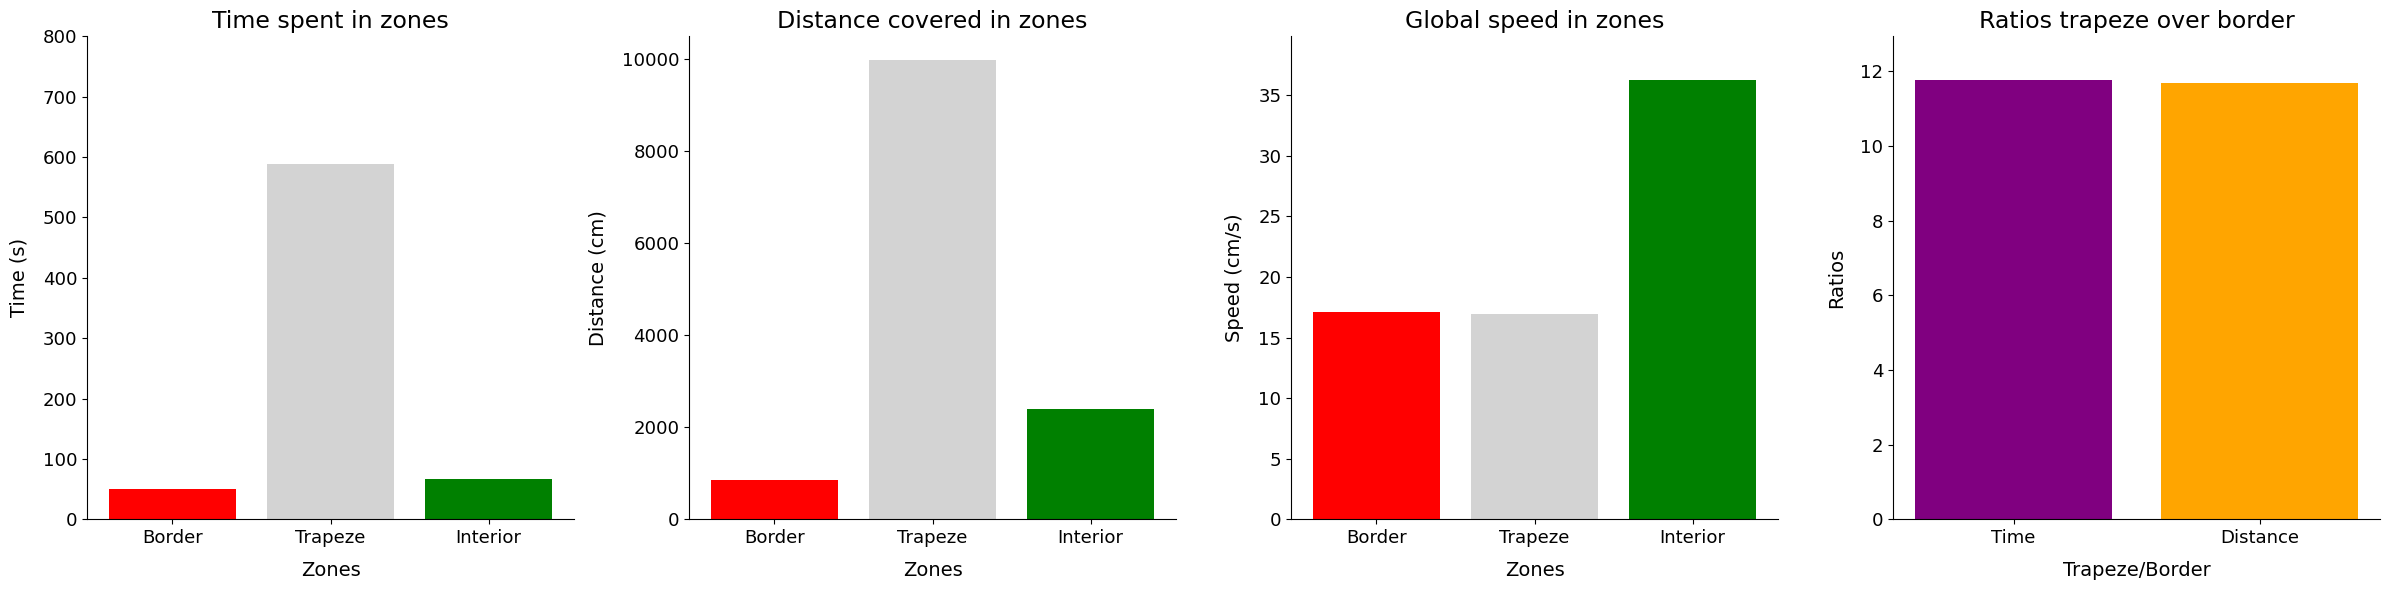

In [112]:
# Function to plot metrics in different zones

def plot_metrics_in_zones(ax, metrics_data, metric_title='Undefined metric', ylabel = 'Undefined y label', ymax=None):
    """
    Parameters:
        ax : axe in which we add the subplot
        metrics_data (list) : list containing all the metrics you want to plot
        metric_title (str) : used to set the title of the graph 
        ylabel (str) : title of the y axis
        ymax : max y coordinate

    """

    # For time data : ymax = 900
    # For distance data: ymax= 10500

    # Tracer la métrique choisie en fonction de la zone
    ax.bar(['Border', 'Trapeze', 'Interior'], metrics_data, color=['red', 'lightgray', 'green'])
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_title(metric_title, fontsize=17)
    ax.set_xlabel('Zones', labelpad=10, fontsize=14)
    ax.set_ylabel(ylabel, labelpad=10, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ymax == None:
        ax.set_ylim(0,max(metrics_data)*1.1)
    else:
        ax.set_ylim(0, ymax)


def plot_ratios_in_zones(ax, ratios_data, title_ratio = 'Undefined title', xlabel = 'Undefined label', ymax=None):
    
    # Plot the trapeze/border ratios for time and distance
    ax.bar(['Time', 'Distance'], ratios_data, color=['purple', 'orange'])
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_title(title_ratio, fontsize=17)
    ax.set_xlabel(xlabel, labelpad=10, fontsize=14)
    ax.set_ylabel('Ratios', labelpad=10, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ymax == None:
        ax.set_ylim(0,max(ratios_data)*1.1)
    else:
        ax.set_ylim(0, ymax)
    

# Datas to plot
time_zones_data = [time_in_border, time_in_trapeze, time_in_interior]
distance_zones_data = [distance_in_border, distance_in_trapeze, distance_in_interior]
speed_zones_data = [speed_border, speed_trapezes, speed_interior]
ratios_trapeze_over_border = [round(ratio_time_trapeze_border, 2), round(ratio_distance_trapeze_border, 2)]

# Creation of the figure and call the functions to create the subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
plot_metrics_in_zones(axs[0], time_zones_data, metric_title='Time spent in zones', ylabel = 'Time (s)', ymax=800)
plot_metrics_in_zones(axs[1], distance_zones_data, metric_title='Distance covered in zones', ylabel = 'Distance (cm)', ymax=10500)
plot_metrics_in_zones(axs[2], speed_zones_data, metric_title='Global speed in zones', ylabel = 'Speed (cm/s)', ymax=None)
plot_ratios_in_zones(axs[3], ratios_trapeze_over_border, title_ratio='Ratios trapeze over border', xlabel = 'Trapeze/Border', ymax=None)

plt.tight_layout()
plt.show()

### Plot QT related graphs

In [12]:
# Create a color map for further analysis

def custom_cmap(num_points):
    colors = [(0, 1, 0), (1, 0.5, 0), (1, 0, 0)] # Green to orange to red
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    return [cmap(i / (num_points - 1)) for i in range(num_points)]


In [13]:
# Extract CW and CCW info from pickle here 
all_results_CW_CCW = run_around_tower_results['All']

# Extraire les valeurs spécifiques
total_CW = all_results_CW_CCW['total_CW']
total_CCW = all_results_CW_CCW['total_CCW']
rewarded_CW = all_results_CW_CCW['rewarded_CW']
rewarded_CCW = all_results_CW_CCW['rewarded_CCW']

# Afficher les résultats
print("total_CW:", total_CW)
print("total_CCW:", total_CCW)
print("rewarded_CW:", rewarded_CW)
print("rewarded_CCW:", rewarded_CCW)


total_CW: 143
total_CCW: 109
rewarded_CW: 48
rewarded_CCW: 26


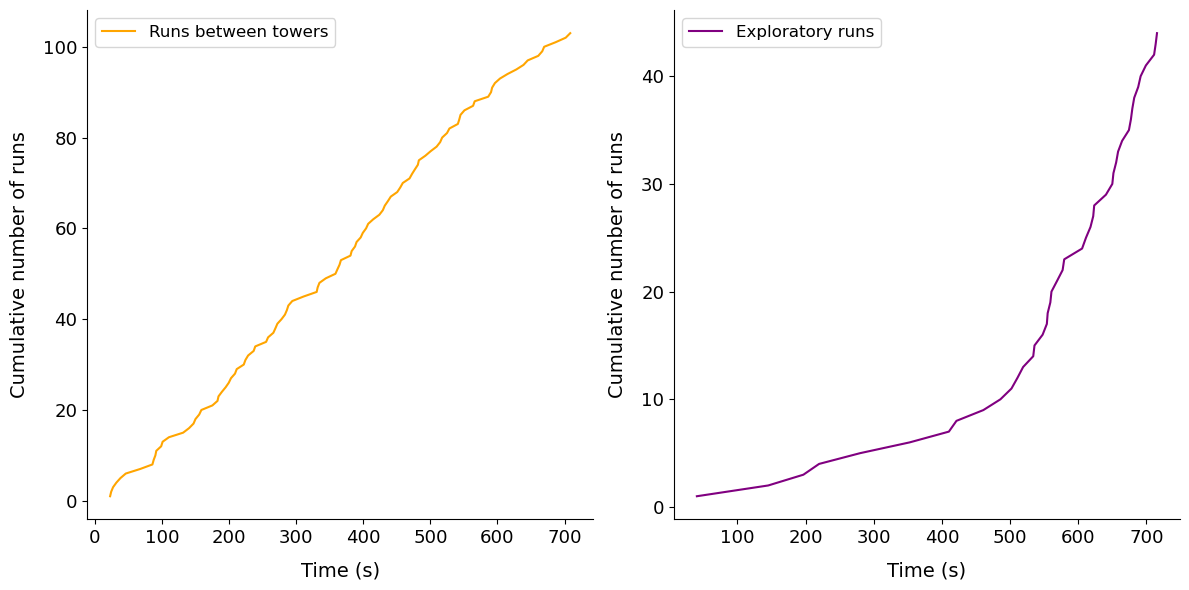

In [124]:
# Plot the cumulative number of run between towers and exploratory runs
# TO DO : transform into a function where you choose the run type again
# TO DO BONUS : create a cell at the begining of the code to define every variable

# Extraire les données des runs between towers et exploratory runs
runs_between_towers = data['all_epochs']['run_between_towers']
exploratory_runs = data['all_epochs']['exploratory_run']

def plot_cumulative_runs(ax, runs, legend_label='Run type', color='orange', ymax=None):

    # Time extraction
    run_times = np.sort(np.array([run[3]['time'] for run in runs]))

    # Cumulative count
    cumulative_count = np.arange(1, len(run_times)+1)

    # Tracé du graphique cumulatif 
    ax.plot(run_times, cumulative_count, label=legend_label, color=color)
    ax.set_xlabel('Time (s)', labelpad=10, fontsize=14)
    ax.set_ylabel('Cumulative number of runs', labelpad=10, fontsize=14)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    # ax.set_title(f'Cumulative number of {legend_label}', pad=10, fontsize=17)
    ax.legend(fontsize=12, loc='upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_cumulative_runs(axs[0], runs_between_towers, legend_label='Runs between towers', color='orange', ymax=None)
plot_cumulative_runs(axs[1], exploratory_runs, legend_label='Exploratory runs', color='purple', ymax=None)

plt.tight_layout()
plt.show()

In [15]:
# # Function to plot centered trajectory for a specific run type

# def plot_trajectory_type_centered(ax, smoothed_Xpositions, smoothed_Ypositions, run_type, title_type = 'run not defined', axis_lim=80, direction='None', q=4):
#     """
#     Trace la trajectoire de la souris pour le type de run spécifié.
    
#     Paramètres :
#         ax : Axe matplotlib sur lequel dessiner le graphique.
#         smoothed_Xpositions (list) : Positions X lissées.
#         smoothed_Ypositions (list) : Positions Y lissées.
#         run_type (str) : Type de run ('run_between_towers', 'exploratory_run', 'run_around_tower').
#         q (int) : Nombre de points pour calculer la flèche de direction.
#     """
#     # if run_type == 'run_around_tower' and direction is not None:
#     #     runs = all_epochs[run_type]
#     # runs = all_epochs[run_type]

#     fixed_origin = (0, 0)
#     cmap = plt.cm.copper
#     norm = Normalize(vmin=0, vmax=len(run_type))

#     for index, run in enumerate(run_type):
#         start_index, end_index = run[0][0], run[0][1]

#         # Extraction des positions X et Y pour cette période de run
#         runtype_epoch_Xpositions = smoothed_Xpositions[start_index:end_index + 1]
#         runtype_epoch_Ypositions = smoothed_Ypositions[start_index:end_index + 1]
#         numberofpositions = len(runtype_epoch_Xpositions)
#         colorgradientforthisrun = custom_cmap(numberofpositions)
        
#         # Translation de la trajectoire pour que le point de départ soit à l'origine
#         start_x, start_y = runtype_epoch_Xpositions[0], runtype_epoch_Ypositions[0]
#         translated_Xpositions = [x - start_x + fixed_origin[0] for x in runtype_epoch_Xpositions]
#         translated_Ypositions = [y - start_y + fixed_origin[1] for y in runtype_epoch_Ypositions]
        
#         # Tracé de la trajectoire
#         for i in range(numberofpositions - 1):
#             ax.plot(translated_Xpositions[i:i+2], translated_Ypositions[i:i+2], color=colorgradientforthisrun[i], linewidth=0.5)
        
#         # Point de départ en vert
#         ax.plot(translated_Xpositions[0], translated_Ypositions[0], 'go', markersize=3)
        
#         # Tracé de la flèche directionnelle
#         if len(translated_Xpositions) >= q:
#             dx = translated_Xpositions[-1] - translated_Xpositions[-q]
#             dy = translated_Ypositions[-1] - translated_Ypositions[-q]
            
#             norm_speed = np.hypot(dx, dy)
#             if norm_speed != 0:
#                 dx /= norm_speed
#                 dy /= norm_speed
            
#             ax.arrow(translated_Xpositions[-1], translated_Ypositions[-1], dx, dy,
#                      head_width=1, head_length=1, fc='red', ec='red')

#     ax.set_ylabel('Y Position (cm)')
#     ax.set_xlabel('X Position (cm)')
#     ax.set_xlim(-axis_lim, axis_lim)
#     ax.set_ylim(-axis_lim, axis_lim)

#     ax.set_title(f"Trajectoire centrée pour {title_type}")


In [187]:
# Function to plot speed profile of a specific run type

def plot_speed_over_time(ax, traject_time, speeds, run_type, xlim=5.1, set_title=False, title_type = 'run not defined'):
    """
    Trace la vitesse de la souris en fonction du temps pour le type de run spécifié.
    
    Paramètres :
        ax : Axe matplotlib sur lequel dessiner le graphique.
        traject_time (list) : Temps de la trajectoire.
        speeds (list) : Vitesse de la souris.
        runs (list) : Liste des runs pour le type spécifié.
        run_type (str) : Type de run ('between_towers', 'exploratory', 'around_tower').
        color_map (Colormap) : Colormap pour le gradient de couleur.
    """

    # runs = all_epochs[run_type]

    norm = Normalize(vmin=0, vmax=len(run_type))
    color_map = plt.cm.copper
    
    for index, run in enumerate(run_type):
        start_index, end_index = run[0][0], run[0][1]
        adjusted_time = [t - traject_time[start_index] for t in traject_time[start_index:end_index + 1]]
        
        # Tracé de la vitesse
        ax.plot(adjusted_time, speeds[start_index:end_index + 1], color=color_map(norm(index)))

    ax.set_ylabel('Speed (cm/s)', labelpad=10, fontsize=14)
    ax.set_xlabel('Time (s)', labelpad=10, fontsize=14)
    ax.set_ylim(0, 80)
    ax.set_xlim(0, xlim)
    
    if set_title:
        ax.set_title(f"Speed profile for {title_type}", pad=10, fontsize=17)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [ ]:
runs_around_tower_CW = []
runs_around_tower_CCW = []
runs_around_tower_rewarded = []
runs_around_tower_unrewarded = []

for run in runs_around_tower:
    if run[3]['direction'] == 'CW':
        runs_around_tower_CW.append(run)
    else:
        runs_around_tower_CCW.append(run)

    if run[3]['Rewarded'] == True:
        runs_around_tower_rewarded.append(run)
    else:
        runs_around_tower_unrewarded.append(run)

# print(runs_around_tower_CCW)
# print(runs_around_tower_CW)
# print(runs_around_tower_rewarded)
# print(runs_around_tower_unrewarded)

# print(runs_around_tower[0][4]['epoch_time']) # Test, to delete later

[[[15, 36], ['NE', 'W'], ['NE', 'S'], {'Rewarded': True, 'direction': 'CCW', 'num_trapezeswitch': 1}, {'epoch_time': 15.632, 'epoch_duration': 0.8390000000000004, 'epoch_distance': 20.232556404661377, 'epoch_meanspeed': 24.115085106866946, 'epoch_maxspeed': 47.058545256468655}], [[59, 86], ['NE', 'S'], ['NE', 'E'], {'Rewarded': True, 'direction': 'CCW', 'num_trapezeswitch': 1}, {'epoch_time': 17.39, 'epoch_duration': 1.0829999999999984, 'epoch_distance': 18.704707232579693, 'epoch_meanspeed': 17.27119781401636, 'epoch_maxspeed': 49.03332380141512}], [[96, 113], ['NE', 'E'], ['NE', 'N'], {'Rewarded': True, 'direction': 'CCW', 'num_trapezeswitch': 1}, {'epoch_time': 18.873, 'epoch_duration': 0.6779999999999973, 'epoch_distance': 17.794843576844805, 'epoch_meanspeed': 26.246081971747607, 'epoch_maxspeed': 43.92667974414691}], [[132, 148], ['NE', 'N'], ['NE', 'W'], {'Rewarded': True, 'direction': 'CCW', 'num_trapezeswitch': 1}, {'epoch_time': 20.311, 'epoch_duration': 0.6439999999999984, '

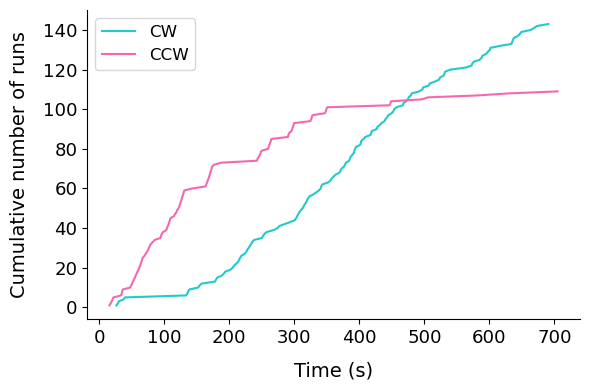

In [118]:
def plot_cumulative_rewarded_unrewarded(ax, runs_around_tower):

    # Create empty lists to store runs
    runs_around_tower_rewarded = []
    runs_around_tower_unrewarded = []

    for run in runs_around_tower:
        if run[3]['Rewarded'] == True:
            runs_around_tower_rewarded.append(run)
        else:
            runs_around_tower_unrewarded.append(run)

    # Extraire les temps des runs "rewarded" et "unrewarded" dans l'ordre croissant
    rewarded_times_sorted = np.sort(np.array([run[4]['epoch_time'] for run in runs_around_tower_rewarded]))
    unrewarded_times_sorted = np.sort(np.array([run[4]['epoch_time'] for run in runs_around_tower_unrewarded]))

    # Calculer les cumulés
    cumulative_rewarded = np.arange(1, len(rewarded_times_sorted) + 1)
    cumulative_unrewarded = np.arange(1, len(unrewarded_times_sorted) + 1)

    # Tracer les courbes cumulatives
    ax.plot(rewarded_times_sorted, cumulative_rewarded, label='Rewarded', color='mediumseagreen')
    ax.plot(unrewarded_times_sorted, cumulative_unrewarded, label='Unrewarded', color='firebrick')


    # Paramètres du graphique
    ax.set_xlabel('Time (s)', labelpad=10, fontsize=14)
    ax.set_ylabel('Cumulative number of runs', labelpad=10, fontsize=14)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    # ax.set_title('Cumulatif des runs Rewarded et Unrewarded')
    ax.legend(fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_cumulative_CW_CCW(ax, runs_around_tower):
    # Create empty lists to store runs
    runs_around_tower_CW = []
    runs_around_tower_CCW = []

    for run in runs_around_tower:
        if run[3]['direction'] == 'CW':
            runs_around_tower_CW.append(run)
        else:
            runs_around_tower_CCW.append(run)

    # Extraire les temps des runs "CW" et "CW" dans l'ordre croissant
    CW_times_sorted = np.sort(np.array([run[4]['epoch_time'] for run in runs_around_tower_CW]))
    CCW_times_sorted = np.sort(np.array([run[4]['epoch_time'] for run in runs_around_tower_CCW]))

    # Calculer les cumulés
    cumulative_CW = np.arange(1, len(CW_times_sorted) + 1)
    cumulative_CCW = np.arange(1, len(CCW_times_sorted) + 1)

    # Tracer les courbes cumulatives
    ax.plot(CW_times_sorted, cumulative_CW, label='CW', color='#22cacaff')
    ax.plot(CCW_times_sorted, cumulative_CCW, label='CCW', color='#f568afff')
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)

    # Paramètres du graphique
    ax.set_xlabel('Time (s)', labelpad=10, fontsize=14)
    ax.set_ylabel('Cumulative number of runs', labelpad=10, fontsize=14)
    # ax.set_title('Cumulative number of runs CW and CCW')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=12)

# Exemple d'utilisation
fig, ax = plt.subplots(figsize=(6, 4))

# Tracer les données sur l'axe
# plot_cumulative_rewarded_unrewarded(axs[0], runs_around_tower)
plot_cumulative_CW_CCW(ax, runs_around_tower)

# Ajustement de la disposition et affichage
plt.tight_layout()
plt.show()


In [19]:
# fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# plot_trajectory_type_centered(axs[0], X_positions_cm, Y_positions_cm, runs_around_tower_CW, title_type='CW runs around tower ', axis_lim=35)
# plot_speed_over_time(axs[1], traject_time, speeds, runs_around_tower_CW, title_type = 'CW runs around tower',xlim=2.1)

# fig, ax = plt.subplots(figsize=(6, 6))

# plot_trajectory_type_centered(ax, X_positions_cm, Y_positions_cm, runs_around_tower_CW, title_type='CW runs around tower ', axis_lim=25)

# plt.tight_layout()
# plt.show()

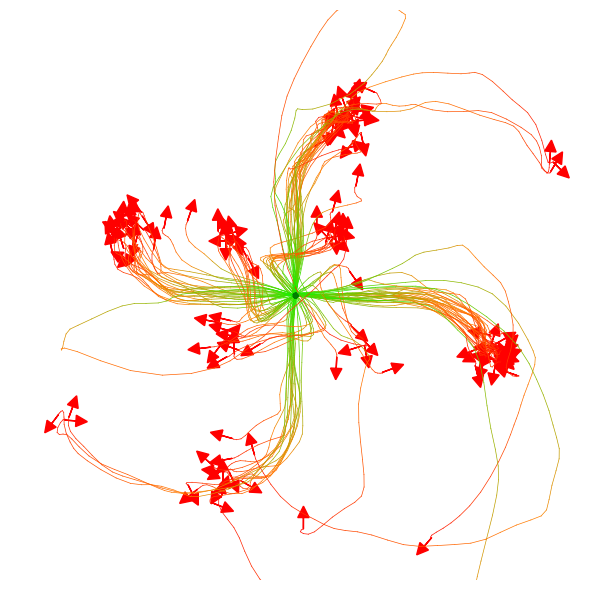

In [20]:
def plot_trajectory_type_centered(ax, smoothed_Xpositions, smoothed_Ypositions, run_type, 
                                  axis_lim=25, direction='None', xlim=30, ylim=30, q=4, line_width=0.5, arrow_width=0.001):
    """
    Trace uniquement la trajectoire, sans cadre ni axes autour de la figure.
    """
    fixed_origin = (0, 0)
    
    for index, run in enumerate(run_type):
        start_index, end_index = run[0][0], run[0][1]
        runtype_epoch_Xpositions = smoothed_Xpositions[start_index:end_index + 1]
        runtype_epoch_Ypositions = smoothed_Ypositions[start_index:end_index + 1]
        numberofpositions = len(runtype_epoch_Xpositions)
        colorgradientforthisrun = custom_cmap(numberofpositions)
        
        start_x, start_y = runtype_epoch_Xpositions[0], runtype_epoch_Ypositions[0]
        translated_Xpositions = [x - start_x + fixed_origin[0] for x in runtype_epoch_Xpositions]
        translated_Ypositions = [y - start_y + fixed_origin[1] for y in runtype_epoch_Ypositions]
        
        for i in range(numberofpositions - 1):
            ax.plot(translated_Xpositions[i:i+2], translated_Ypositions[i:i+2], 
                    color=colorgradientforthisrun[i], linewidth=line_width)
        
        ax.plot(translated_Xpositions[0], translated_Ypositions[0], 'go', markersize=3)
        
        if len(translated_Xpositions) >= q:
            dx = translated_Xpositions[-1] - translated_Xpositions[-q]
            dy = translated_Ypositions[-1] - translated_Ypositions[-q]
            
            norm_speed = np.hypot(dx, dy)
            if norm_speed != 0:
                dx /= norm_speed
                dy /= norm_speed
            
            ax.arrow(translated_Xpositions[-1], translated_Ypositions[-1], dx, dy,
                     head_width=1, head_length=1, width=arrow_width, fc='red', ec='red')

    # Supprime tous les axes et cadres
    ax.set_xlim(-ylim, ylim)
    ax.set_ylim(-xlim, xlim)
    ax.axis('off')

fig, ax = plt.subplots(figsize=(6, 6))

plot_trajectory_type_centered(ax, X_positions_cm, Y_positions_cm, runs_around_tower_CW, xlim=25, ylim=25)

plt.tight_layout()
plt.show()

In [21]:
# assert False, "Stopping execution here."

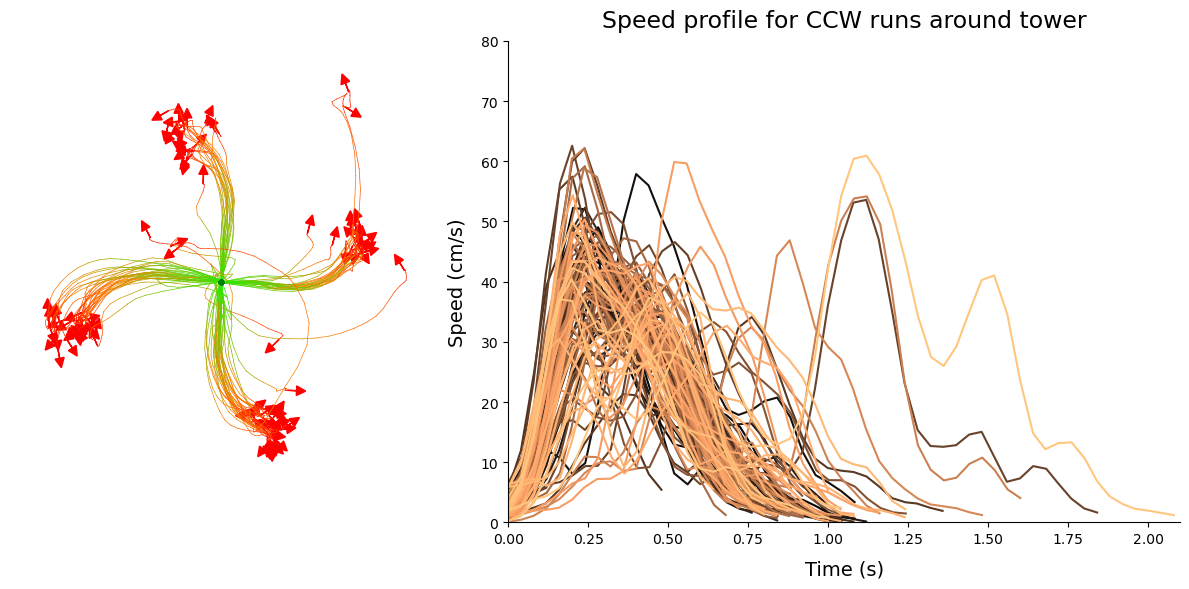

In [165]:
# Crée une figure avec la taille totale souhaitée
fig = plt.figure(figsize=(12, 6))

# Utilise GridSpec pour définir une grille personnalisée
gs = GridSpec(1, 10, figure=fig)  # Divise la largeur totale en 10 parts

# Crée axs[0] avec une largeur de 6/14 (environ 43%)
ax0 = fig.add_subplot(gs[0:4])  # Occupe les colonnes 0 à 3 incluses (4 parts sur 10)

# Crée axs[1] avec une largeur de 8/14 (environ 57%)
ax1 = fig.add_subplot(gs[4:])  # Occupe les colonnes 4 à 9 incluses (6 parts sur 10)

# Tracé des graphiques
plot_trajectory_type_centered(ax0, X_positions_cm, Y_positions_cm, runs_around_tower_CCW, xlim=25, ylim=23)
plot_speed_over_time(ax1, traject_time, speeds, runs_around_tower_CCW, title_type='CCW runs around tower', xlim=2.1)

# Ajuste l'espacement
plt.tight_layout()
plt.show()


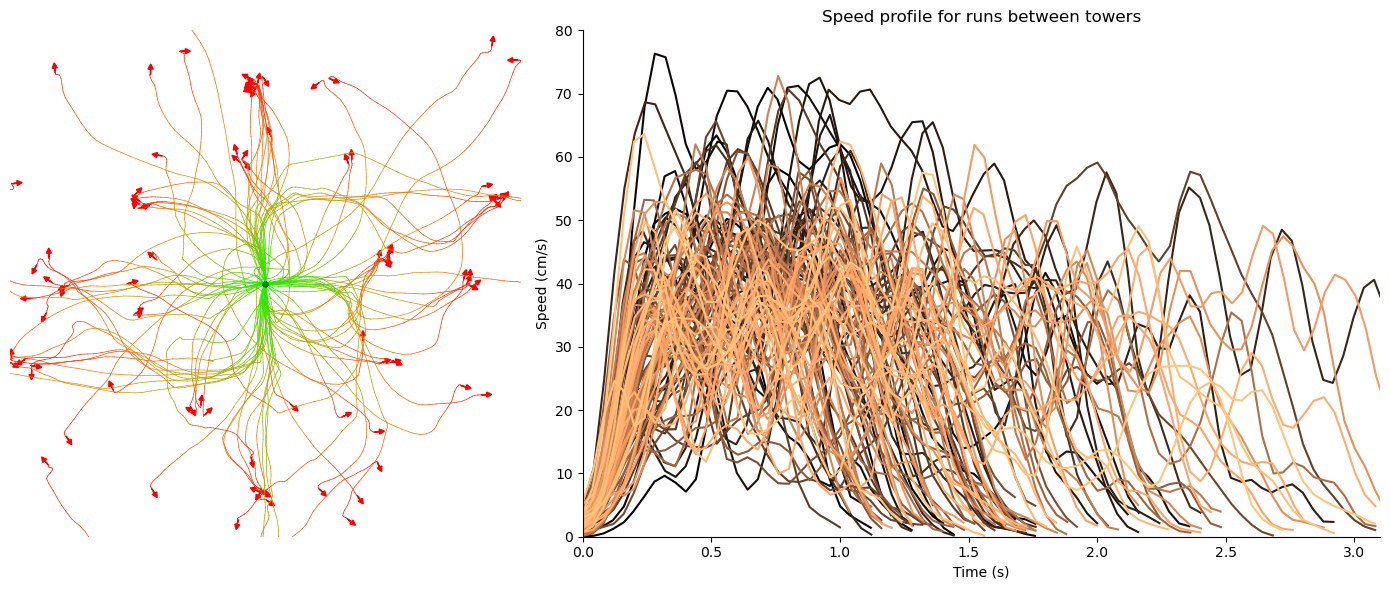

In [51]:
# Crée une figure avec la taille totale souhaitée
fig = plt.figure(figsize=(14, 6))

# Utilise GridSpec pour définir une grille personnalisée
gs = GridSpec(1, 10, figure=fig)  # Divise la largeur totale en 10 parts

# Crée axs[0] avec une largeur de 6/14 (environ 43%)
ax0 = fig.add_subplot(gs[0:4])  # Occupe les colonnes 0 à 3 incluses (4 parts sur 10)

# Crée axs[1] avec une largeur de 8/14 (environ 57%)
ax1 = fig.add_subplot(gs[4:])  # Occupe les colonnes 4 à 9 incluses (6 parts sur 10)

# Tracé des graphiques
plot_trajectory_type_centered(ax0, X_positions_cm, Y_positions_cm, runs_between_towers, xlim=50, ylim=50)
plot_speed_over_time(ax1, traject_time, speeds, runs_between_towers, title_type = 'runs between towers', xlim=3.1)

# Ajuste l'espacement
plt.tight_layout()
plt.show()

# plot_trajectory_type_centered(axs[0], X_positions_cm, Y_positions_cm, runs_between_towers, title_type = 'runs between towers')



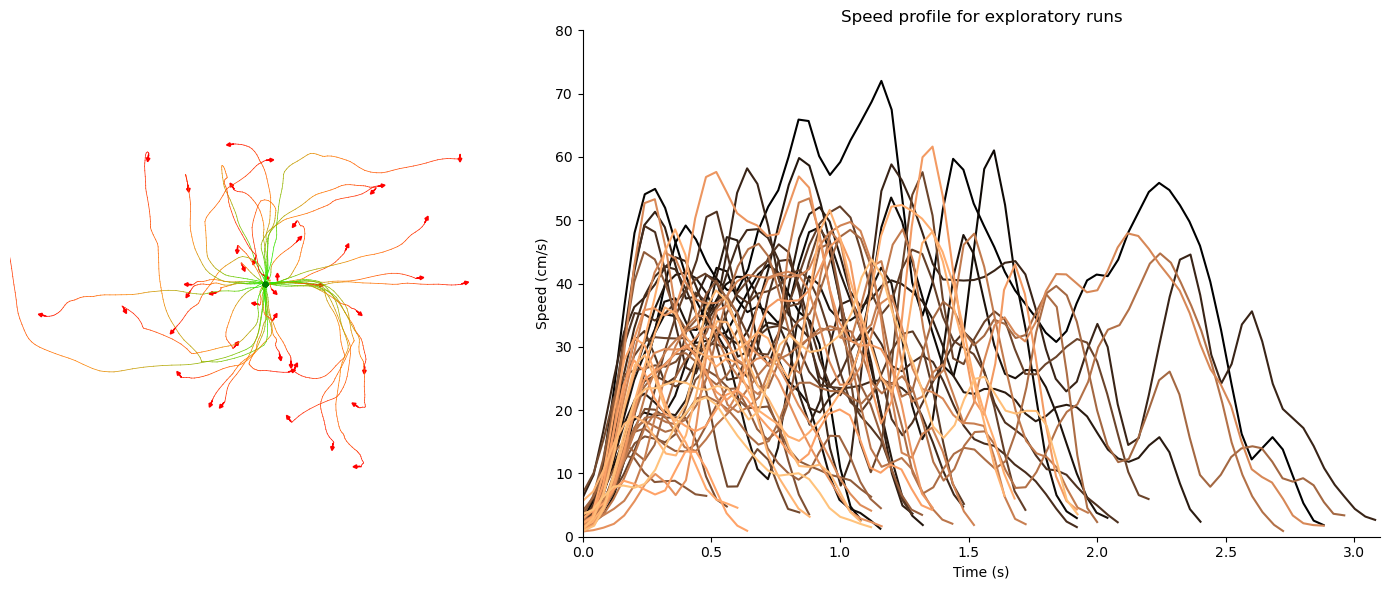

In [52]:
fig = plt.figure(figsize=(14, 6))

# Utilise GridSpec pour définir une grille personnalisée
gs = GridSpec(1, 10, figure=fig)  # Divise la largeur totale en 10 parts

# Crée axs[0] avec une largeur de 6/14 (environ 43%)
ax0 = fig.add_subplot(gs[0:4])  # Occupe les colonnes 0 à 3 incluses (4 parts sur 10)

# Crée axs[1] avec une largeur de 8/14 (environ 57%)
ax1 = fig.add_subplot(gs[4:])  # Occupe les colonnes 4 à 9 incluses (6 parts sur 10)

# Tracé des graphiques
plot_trajectory_type_centered(ax0, X_positions_cm, Y_positions_cm, exploratory_runs, xlim=70, ylim=70)
plot_speed_over_time(ax1, traject_time, speeds, exploratory_runs, title_type = 'exploratory runs', xlim=3.1)

# Ajuste l'espacement
plt.tight_layout()
plt.show()


In [25]:
def plot_maze_towers_with_results(vertices, towers_coordinates, results):
    """
    Plots the edges of a tower or trapeze based on given vertices, 
    and adds behavior data as text inside the plotted shape.
    
    Parameters:
        vertices (list of tuples): List of (x, y) coordinates for the corners of the tower/trapeze.
        color (str): Color code for the plot (e.g., 'r' for red).
        results (dict): Dictionary containing behavioral data with keys 'rewarded_CW', 'total_CW', 
                        'rewarded_CCW', and 'total_CCW'.
        
    """
    for tower_name, vertices in towers_coordinates.items():
        # Fermer le polygone en ajoutant le premier sommet à la fin
        closed_vertices = vertices + [vertices[0]]
        closed_vertices = list(zip(*closed_vertices))  # Transpose vertices for plotting (x, y)
        
        # Calculer le centre du polygone pour afficher le texte au centre
        center_x = sum(v[0] for v in vertices) / len(vertices)
        center_y = sum(v[1] for v in vertices) / len(vertices)

        # Extraire les résultats pour le tour spécifié
        if tower_name in results:
            tower_results = results[tower_name]
            # total_rewards[tower_name] = tower_results['rewarded_CCW'] + tower_results['rewarded_CW']
            # total_turns[tower_name] = tower_results['total_CCW'] + tower_results['total_CW']
            # Texte avec les données comportementales pour le tour
            behavior_text = (f"{tower_name}\n"
                                f"Rewarded/Tot\n"
                                f"CW: {tower_results['rewarded_CW']}/{tower_results['total_CW']}\n"
                                f"CCW: {tower_results['rewarded_CCW']}/{tower_results['total_CCW']}")
            
            # Ajouter le texte au centre du polygone
            plt.text(center_x, center_y, behavior_text, fontsize=8, ha='center', va='center', color='black')
        else:
            print(f"Warning: Tower name '{tower_name}' not found in results.")


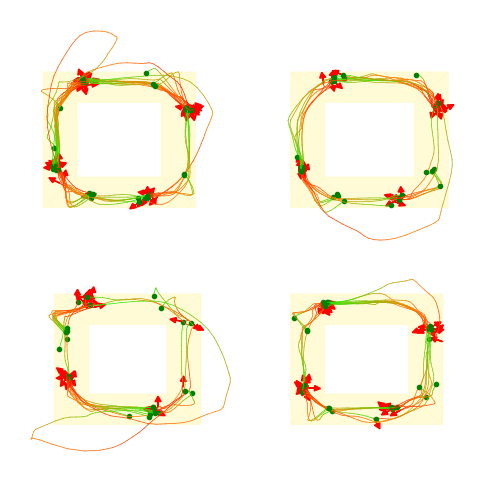

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))

# Supprimer les cadres et graduations
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Définir la couleur pour remplir les trapèzes et leurs bordures
fill_color = 'lemonchiffon'

# Dessiner les trapèzes (en laissant le centre vide)
for tower, trapezes in trapezes_coordinates.items():
    for trapeze, coordinates in trapezes.items():
        # Fermer le polygone pour dessiner le trapèze
        coordinates_copy = coordinates + [coordinates[0]]
        x_coords, y_coords = zip(*coordinates_copy)

        # Remplir le trapèze
        ax.fill(x_coords, y_coords, color=fill_color, alpha=0.8)

        # Dessiner le contour du trapèze
        # ax.plot(x_coords, y_coords, color=border_color, linestyle='-', linewidth=0.5)

# Tracer les trajectoires
q = 4

for run in runs_around_tower_CW:
    start_index, end_index = run[0][0], run[0][1]
    total_nb = len(runs_around_tower_CW)

    # Extraire les données de trajectoire
    run_X_position = X_positions_cm[start_index:end_index + 1]
    run_Y_position = Y_positions_cm[start_index:end_index + 1]

    # Tracer la trajectoire
    numberofpositions = len(run_X_position)
    colorgradientforthisrun = custom_cmap(numberofpositions)

    for k in range(numberofpositions - 1):
        ax.plot(run_X_position[k:k+2], run_Y_position[k:k+2], linestyle='-', linewidth=0.5, color=colorgradientforthisrun[k])

    # Points de départ et d'arrivée
    ax.plot(run_X_position[0], run_Y_position[0], 'go', markersize=3)  # Point de départ

    # Flèche directionnelle
    if len(run_X_position) >= q:
        dx = run_X_position[-1] - run_X_position[-q]
        dy = run_Y_position[-1] - run_Y_position[-q]
        
        # Normalisation de la direction
        norm = np.hypot(dx, dy)
        if norm != 0:
            dx /= norm
            dy /= norm
        
        # Tracer la flèche
        ax.arrow(run_X_position[-1], run_Y_position[-1], dx, dy,
                 head_width=1, head_length=1, fc='red', ec='red')

# Supprimer les axes et les titres
plt.axis('off')

# Afficher la figure
plt.show()


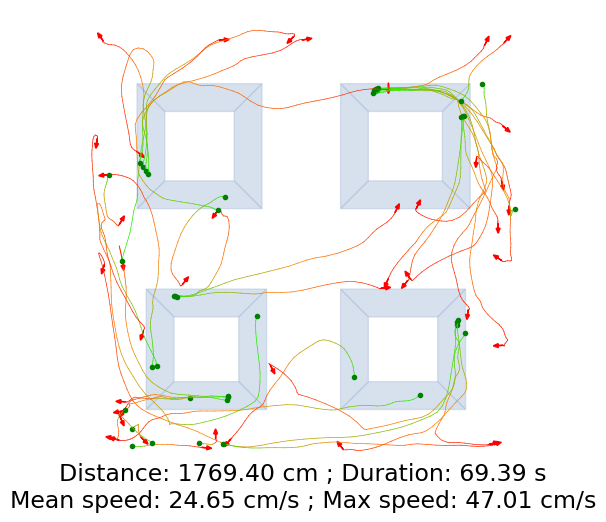

In [ ]:
def plot_run_trajectories(ax, trapezes_coordinates, run_type, traject_time, distances, 
                          X_positions_cm, Y_positions_cm, speeds, towers_coordinates, run_label='Undefined run label', q=4):
    """
    Plots run trajectories around towers, including towers and behavioral data.

    Parameters:
        ax (matplotlib.axes.Axes): Matplotlib Axes on which to plot.
        run_label (str): Label describing the type of runs (e.g., "runs around towers").
        q (int): Minimum number of points to compute and display direction arrows.
        trapezes_coordinates (dict): Coordinates of trapezoidal regions for each tower.
        run_type (list of tuples): List of runs, where each run is represented as [(start, end), ...].
        traject_time (list): Time values corresponding to the trajectory points.
        distances (list): Distance values for each point in the trajectory.
        X_positions_cm (list): X-coordinates of positions in the trajectory.
        Y_positions_cm (list): Y-coordinates of positions in the trajectory.
        speeds (list): Speed values at each point in the trajectory.
        towers_coordinates (dict): Dictionary with tower names as keys and coordinates for each tower as values.
    """
    # Colors for plotting
    fill_colors = ['lightsteelblue'] * 4

    # Remove spines and ticks from the plot
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot each trapezoid region with colors and borders
    for i, (tower, trapezes) in enumerate(trapezes_coordinates.items()):
        for j, (trapeze, coordinates) in enumerate(trapezes.items()):
            coordinates_copy = coordinates + [coordinates[0]]
            x_coords, y_coords = zip(*coordinates_copy)
            ax.fill(x_coords, y_coords, color=fill_colors[j % len(fill_colors)], alpha=0.5)

    # Initialize counters and lists for run analysis
    total_time = 0
    total_distance = 0
    meanspeed = []
    maxspeed = []

    # Plot each run trajectory
    for run in run_type:
        start_index, end_index = run[0][0], run[0][1]
        run_X_position = X_positions_cm[start_index:end_index + 1]
        run_Y_position = Y_positions_cm[start_index:end_index + 1]
        run_duration = traject_time[end_index] - traject_time[start_index]
        distance_ran = np.sum(distances[start_index:end_index])

        # Accumulate metrics
        total_time += run_duration
        total_distance += distance_ran
        meanspeed.append(distance_ran / run_duration)
        maxspeed.append(np.max(speeds[start_index:end_index]))

        # Plot run trajectory with gradient color
        numberofpositions = len(run_X_position)
        colorgradientforthisrun = custom_cmap(numberofpositions)
        for k in range(numberofpositions - 1):
            ax.plot(run_X_position[k:k+2], run_Y_position[k:k+2], linestyle='-', 
                    color=colorgradientforthisrun[k], linewidth=0.5)

        # Plot start point of the run
        ax.plot(run_X_position[0], run_Y_position[0], 'go', markersize=3)

        # Plot arrow if the trajectory has enough points
        if len(run_X_position) >= q:
            dx = run_X_position[-1] - run_X_position[-q]
            dy = run_Y_position[-1] - run_Y_position[-q]
            norm = np.hypot(dx, dy)
            if norm != 0:
                dx /= norm
                dy /= norm
            ax.arrow(run_X_position[-1], run_Y_position[-1], dx, dy, 
                     head_width=0.8, head_length=1, fc='red', ec='red')

    # Plot towers with results if specified
    if run_label == 'runs around towers':
        plot_maze_towers_with_results(towers_coordinates, towers_coordinates, run_around_tower_results)

    # Set the main title with computed metrics
    text = (f"Distance: {total_distance:.2f} cm ; Duration: {total_time:.2f} s\n"
            f"Mean speed: {np.median(meanspeed):.2f} cm/s ; Max speed: {np.median(maxspeed):.2f} cm/s")
    # ax.set_title(f"Trajectory of {run_label}", fontsize=20)
    ax.set_xlabel(text, fontsize=17, labelpad=-10)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_run_trajectories(ax, trapezes_coordinates, exploratory_runs, traject_time, distances, 
                          X_positions_cm, Y_positions_cm, speeds, towers_coordinates, run_label='exploratory runs', q=4)

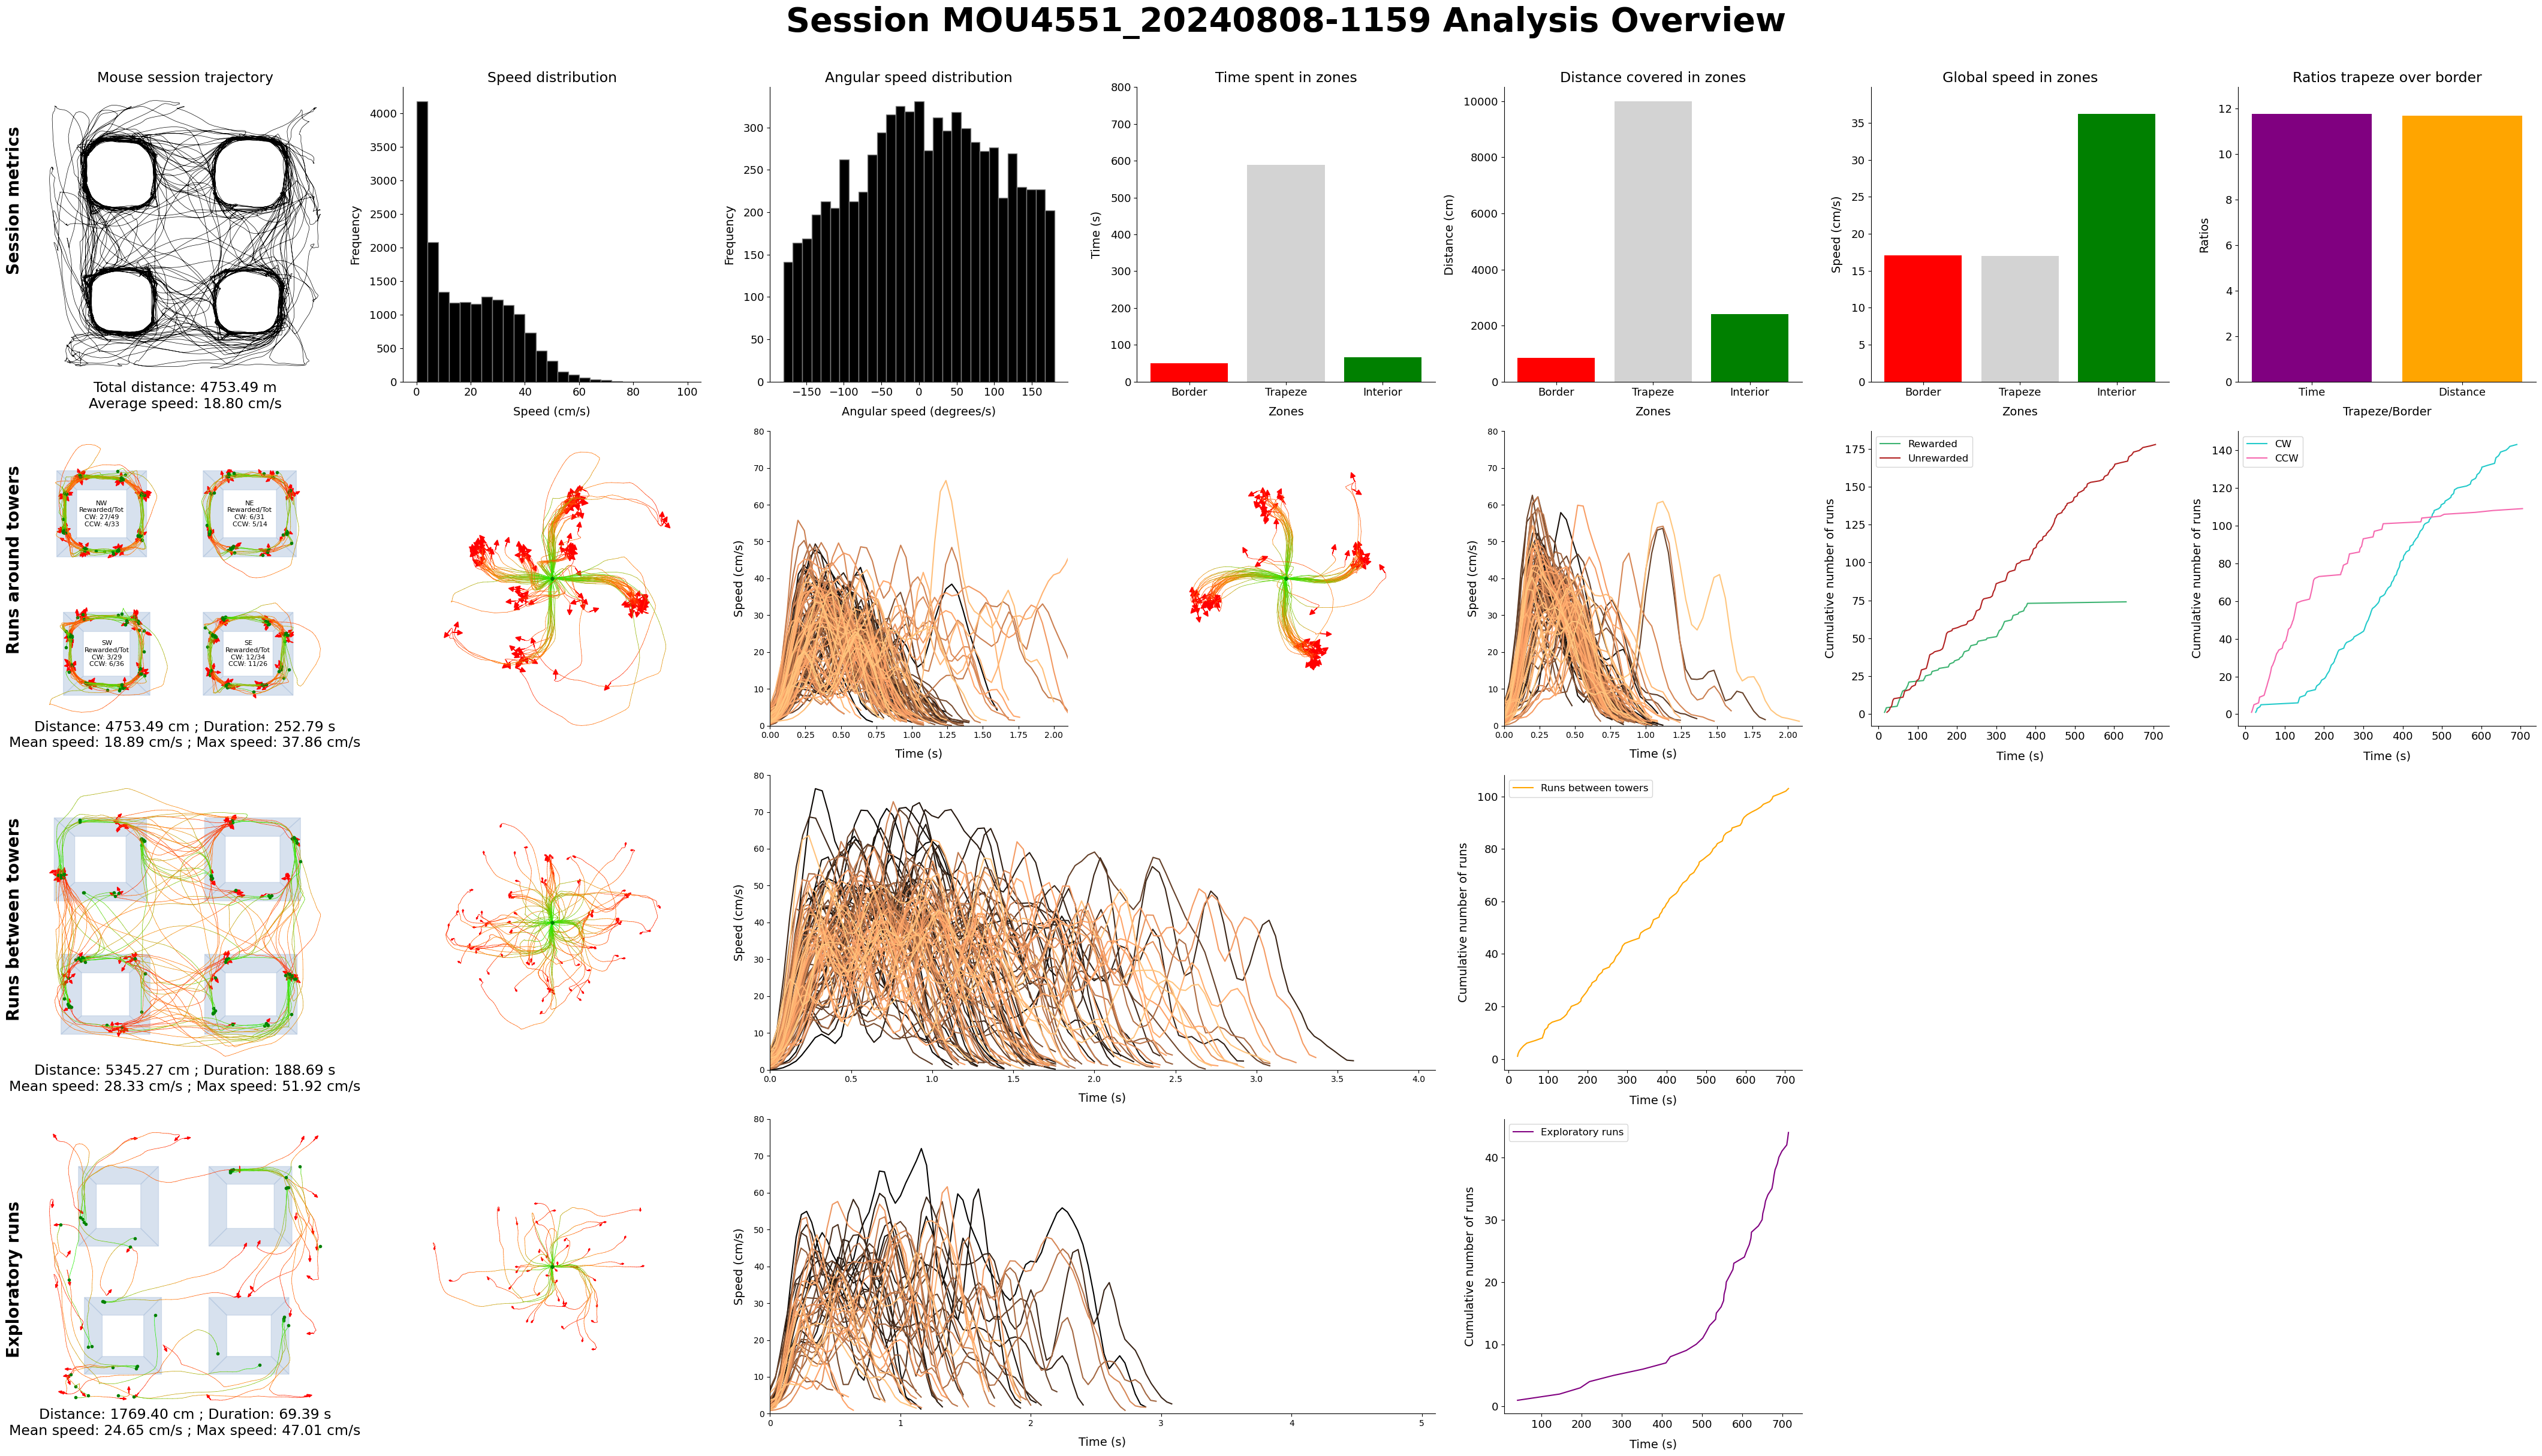

In [191]:
def generate_session_figure(fig, n_rows, n_cols):# Creation of the grid
    # Dimensions de chaque carré
    # Utilisation de GridSpec pour une grille flexible
    gs = GridSpec(n_rows, n_cols, figure=fig)

    # Line 1: full session analysis

    # Global trajectory and metrics (column 1)
    ax_trajectory = fig.add_subplot(gs[0, 0])
    plot_trajectory(ax_trajectory, X_positions_cm, Y_positions_cm, total_distance, average_speed)

    # Speed distribution (column 2)
    ax_speed_distribution = fig.add_subplot(gs[0, 1])
    plot_speed_distribution(ax_speed_distribution, speeds)

    # Angular speed distribution (column 3)
    ax_angular_speed_distribution = fig.add_subplot(gs[0, 2])
    plot_angular_speed_distribution(ax_angular_speed_distribution, angular_speeds)

    # Time spent in zones(column 4)
    ax_time = fig.add_subplot(gs[0, 3])
    plot_metrics_in_zones(ax_time, time_zones_data, metric_title='Time spent in zones', ylabel='Time (s)', ymax=800)

    # Distance in zones (column 5)
    ax_distance = fig.add_subplot(gs[0, 4])
    plot_metrics_in_zones(ax_distance, distance_zones_data, metric_title='Distance covered in zones', ylabel='Distance (cm)', ymax=10500)

    # Speed in zones (column 6)
    ax_speed = fig.add_subplot(gs[0, 5])
    plot_metrics_in_zones(ax_speed, speed_zones_data, metric_title='Global speed in zones', ylabel='Speed (cm/s)', ymax=None)

    # Ratios of time and distance in trapeze vs border (column 7)
    ax_ratios = fig.add_subplot(gs[0, 6])
    plot_ratios_in_zones(ax_ratios, ratios_trapeze_over_border, title_ratio='Ratios trapeze over border', xlabel='Trapeze/Border', ymax=None)


    # Line 2 : runs around tower analysis

    # gs2 = gs[1, 1:3].subgridspec(1,2, width_ratios=[4,6])
    # gs3 = gs[1, 3:5].subgridspec(1,2, width_ratios=[4,6])

    # Trajectory of all runs around tower (column 1)
    ax_traj_QT = fig.add_subplot(gs[1,0])
    plot_run_trajectories(ax_traj_QT, trapezes_coordinates, runs_around_tower, traject_time, distances, 
                            X_positions_cm, Y_positions_cm, speeds, towers_coordinates, run_label='runs around towers', q=4)

    # Trajectory and speeds of CW turns (columns 2 and 3)
    ax_CW_QT_trajectories = fig.add_subplot(gs[1,1])
    plot_trajectory_type_centered(ax_CW_QT_trajectories, X_positions_cm, Y_positions_cm, runs_around_tower_CW, xlim=30, ylim=30)
    ax_CW_QT_trajectories.set_aspect('equal', adjustable='box')

    ax_CW_QT_speeds = fig.add_subplot(gs[1,2])
    plot_speed_over_time(ax_CW_QT_speeds, traject_time, speeds, runs_around_tower_CW, xlim=2.1, set_title=False, title_type = 'CW runs around tower')
    # ax_CW_QT_speeds.set_aspect('auto', adjustable='box')

    # Trajectory and speeds of CCW turns (columns 4 and 5)
    ax_CCW_QT_trajectories = fig.add_subplot(gs[1,3])
    plot_trajectory_type_centered(ax_CCW_QT_trajectories, X_positions_cm, Y_positions_cm, runs_around_tower_CCW, xlim=30, ylim=30)
    ax_CW_QT_trajectories.set_aspect('equal', adjustable='box')

    ax_CCW_QT_speeds = fig.add_subplot(gs[1,4])
    plot_speed_over_time(ax_CCW_QT_speeds, traject_time, speeds, runs_around_tower_CCW, xlim=2.1, set_title=False, title_type = 'CCW runs around tower')
    # ax_CW_QT_speeds.set_aspect('auto', adjustable='box')

    # Cumulative number of CCW/CW (column 6)
    ax_cumul_CW_CCW = fig.add_subplot(gs[1,5])
    plot_cumulative_rewarded_unrewarded(ax_cumul_CW_CCW, runs_around_tower)

    # Cumulative number of rewarded/unrewarded (column 7)
    ax_cumul_rewarded_unrewarded = fig.add_subplot(gs[1,6])
    plot_cumulative_CW_CCW(ax_cumul_rewarded_unrewarded, runs_around_tower)


    # Line 3 : runs between towers analysis

    # Trajectory of all runs between towers (column 1)
    ax_traj_BT = fig.add_subplot(gs[2,0])
    plot_run_trajectories(ax_traj_BT, trapezes_coordinates, runs_between_towers, traject_time, distances, 
                            X_positions_cm, Y_positions_cm, speeds, towers_coordinates, run_label='runs between towers', q=4)

    # Centered trajectory (column 2)
    ax_trajectory = fig.add_subplot(gs[2, 1])
    plot_trajectory_type_centered(ax_trajectory, X_positions_cm, Y_positions_cm, runs_between_towers, xlim=90, ylim=90)

    # Speed profiles (columns 3 and 4)
    ax_speed = fig.add_subplot(gs[2, 2:4])
    plot_speed_over_time(ax_speed, traject_time, speeds, runs_between_towers, title_type='runs between towers', xlim=4.1)

    # Cumulative number of runs between towers (column 5)
    ax_cumul_nb_of_BT = fig.add_subplot(gs[2,4])
    plot_cumulative_runs(ax_cumul_nb_of_BT, runs_between_towers, legend_label='Runs between towers', color='orange', ymax=None)


    # Line 4 : exploratory runs analysis

    # Trajectory of all exploratory runs (column 1)
    ax_traj_ER = fig.add_subplot(gs[3,0])
    plot_run_trajectories(ax_traj_ER, trapezes_coordinates, exploratory_runs, traject_time, distances, 
                            X_positions_cm, Y_positions_cm, speeds, towers_coordinates, run_label='exploratory runs', q=4)

    # Centered trajectory (column 2)
    ax_trajectory = fig.add_subplot(gs[3, 1])
    plot_trajectory_type_centered(ax_trajectory, X_positions_cm, Y_positions_cm, exploratory_runs, xlim=90, ylim=90)

    # Speed profiles (columns 3 and 4)
    ax_speed = fig.add_subplot(gs[3, 2:4])
    plot_speed_over_time(ax_speed, traject_time, speeds, exploratory_runs, title_type='exploratory runs')

    # Cumulative number of exploratory runs (column 5)
    ax_cumul_nb_of_ER = fig.add_subplot(gs[3,4])
    plot_cumulative_runs(ax_cumul_nb_of_ER, exploratory_runs, legend_label='Exploratory runs', color='purple', ymax=None)


    # Handle texts and fig params

    fig.suptitle(f"Session {session_to_process} Analysis Overview", fontsize=40, fontweight='bold', y=1.01)
    fig.text(-0.005, 0.875, 'Session metrics', ha='center', va='center', rotation=90, fontsize=20, fontweight='bold')
    fig.text(-0.005, 0.625, 'Runs around towers', ha='center', va='center', rotation=90, fontsize=20, fontweight='bold')
    fig.text(-0.005, 0.375, 'Runs between towers', ha='center', va='center', rotation=90, fontsize=20, fontweight='bold')
    fig.text(-0.005, 0.125, 'Exploratory runs', ha='center', va='center', rotation=90, fontsize=20, fontweight='bold')

    plt.subplots_adjust(hspace=2)


# Size of the figure
square_size = 6
n_cols = 7
n_rows = 4
figsize = (n_cols * square_size, n_rows * square_size)

# Creation and visualization of the figure
fig = plt.figure(figsize=figsize)
generate_session_figure(fig, n_rows, n_cols)
plt.tight_layout()

# Register as pdf
output_path = f"/home/david/Pictures/PDF_figure/{session_to_process}_figure.pdf" 
plt.savefig(output_path, format="pdf", bbox_inches="tight")

plt.show()
